# Machine Learning Practice

----

## 贷款审批结果预测

银行的放贷审批，核心要素为风险控制。因此，对于申请人的审查关注的要点为违约可能性。而违约可能性通常由申请人收入情况、稳定性、贷款数额及偿还年限等因素来衡量。该项目根据申请人条件，进一步细化得到各个变量对于违约评估的影响，从而预测银行是否会批准贷款申请。在项目实现过程中使用了经典的机器学习算法，对申请贷款客户进行科学归类，从而帮助金融机构提高对贷款信用风险的控制能力。

数据来自竞赛
https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

----

## 1. 数据读取

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
path = './data/loan_records.csv'
df = pd.read_csv(path)

### 1.1 数据预览

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
print('数据集一共有{}行，{}列'.format(df.shape[0], df.shape[1]))

数据集一共有614行，13列


从贷款数据样本中，可以观察得到数据的特征

- Loan_ID：样本标号
- Gender：贷款人性别 (Male/ Female)
- Married：是否结婚 (Y/N)
- Dependents：供养人数
- Education: 受教育程度 (Graduate/ Not Graduate)
- Self_Employed：是否自雇 (Y/N)
- ApplicantIncome：申请人收入
- CoapplicantIncome：联合申请人收入
- LoanAmount：贷款金额（单位：千）
- Loan_Amount_Term：贷款期限（单位：月）
- Credit_History：历史信用是否达标（0/1）
- Property_Area：居住地区（Urban/ Semi Urban/ Rural）
- Loan_Status：是否批准（Y/N）

### 1.2 数据统计信息

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


观察数据情况可以发现
- LoanAmount、Loan_Amount_Term、Credit_History有明显的缺失值，需要进行空值处理

----

## 2. 数据处理

### 2.1 重复值处理

In [7]:
sum(df['Loan_ID'].duplicated())

0

数据集不存在重复样本

### 2.2 缺失值处理

In [8]:
# 查看存在缺失值的情况
for col in df.columns:
    empty_count = df[col].isnull().sum()
    if empty_count != 0:
        print('{} 空记录数为：{}'.format(col, empty_count))

Gender 空记录数为：13
Married 空记录数为：3
Dependents 空记录数为：15
Self_Employed 空记录数为：32
LoanAmount 空记录数为：22
Loan_Amount_Term 空记录数为：14
Credit_History 空记录数为：50


In [9]:
# 将存在空值的样本删除
clean_df = df.dropna()
print('原始样本数为{}，清理后的样本数为{}'.format(df.shape[0], clean_df.shape[0]))

原始样本数为614，清理后的样本数为480


### 2.3 特殊值处理

数值列Dependents包含3+，将其全部转换为3

In [10]:
clean_df['Dependents'] = clean_df['Dependents'].apply(lambda x: '3' if x == '3+' else x)

### 2.4 特征数据和标签数据提取

在该数据集中，共有以下三种特征列

1. 数值型特征列
    - Dependents：供养人数
    - ApplicantIncome：申请人收入
    - CoapplicantIncome：联合申请人收入
    - LoanAmount：贷款金额（单位：千）
    - Loan_Amount_Term：贷款期限（单位：月）
2. 有序型特征
    - Education: 受教育程度 (Graduate/ Not Graduate)
    - Credit_History：历史信用是否达标（0/1）
3. 类别型特征
    - Gender：贷款人性别 (Male/ Female)
    - Married：是否结婚 (Y/N)
    - Self_Employed：是否自雇 (Y/N)
    - Property_Area：居住地区（Urban/ Semi Urban/ Rural）

In [11]:
# 按数据类型指定特征列
# 1. 数值型特征列
num_cols = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# 2. 有序型特征
ord_cols = ['Education', 'Credit_History']

# 3. 类别型特征
cat_cols = ['Gender', 'Married', 'Self_Employed', 'Property_Area']

# 特征数据
feat_cols = num_cols + ord_cols + cat_cols
feat_df = clean_df[feat_cols]

In [12]:
# 将列类型转换为数值类型
feat_df[num_cols] = feat_df[num_cols].apply(pd.to_numeric)

In [13]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 1 to 613
Data columns (total 11 columns):
Dependents           480 non-null int64
ApplicantIncome      480 non-null int64
CoapplicantIncome    480 non-null float64
LoanAmount           480 non-null float64
Loan_Amount_Term     480 non-null float64
Education            480 non-null object
Credit_History       480 non-null float64
Gender               480 non-null object
Married              480 non-null object
Self_Employed        480 non-null object
Property_Area        480 non-null object
dtypes: float64(4), int64(2), object(5)
memory usage: 45.0+ KB


### 2.5 划分训练集和测试集

In [14]:
# 将 Loan_Status 列中的标签Y转换为1，标签N转换为0，并保存到labels中
labels = clean_df['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feat_df, labels, random_state=1, test_size=1/4)
print('训练集有{}条记录，测试集有{}条记录。'.format(X_train.shape[0], X_test.shape[0]))

训练集有360条记录，测试集有120条记录。


----

## 3 特征处理

### 3.1 有序型特征处理

有序型特征中Credit_History已经是数值，只需要转换Education列就即可：将Graduate转为1，Under Graduate转为0

In [16]:
# 在训练集上做处理
X_train.loc[X_train['Education'] == 'Graduate', 'Education'] = 1
X_train.loc[X_train['Education'] == 'Not Graduate', 'Education'] = 0

# 在测试集上做处理
X_test.loc[X_test['Education'] == 'Graduate', 'Education'] = 1
X_test.loc[X_test['Education'] == 'Not Graduate', 'Education'] = 0

In [17]:
# 获取有序型特征处理结果
train_ord_feats = X_train[ord_cols].values
test_ord_feats = X_test[ord_cols].values

### 3.2 类别型特征处理

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

In [19]:
# Build function to process category features
def encode_cat_feats(train_df, test_df, cat_col):
    """
        对某列类别型数据进行编码
    """
    
    label_enc = LabelEncoder()
    one_hot_enc = OneHotEncoder(sparse=False)
    
    # 类别型数据
    train_cat_feat = train_df[cat_col].values
    test_cat_feat = test_df[cat_col].values
    
    # 在训练集上处理
    processing_train_cat_feat = label_enc.fit_transform(train_cat_feat).reshape(-1, 1)
    processing_train_cat_feat = one_hot_enc.fit_transform(processing_train_cat_feat)

    # 在测试集上处理
    processing_test_cat_feat = label_enc.transform(test_cat_feat).reshape(-1, 1)
    processing_test_cat_feat = one_hot_enc.transform(processing_test_cat_feat)
    
    return processing_train_cat_feat, processing_test_cat_feat

In [20]:
# 初始化编码处理后的特征
enc_train_cat_feats = None
enc_test_cat_feats = None

In [21]:
# 对每个类别型特征进行编码处理
for cat_col in cat_cols:
    enc_train_cat_feat, enc_test_cat_feat = encode_cat_feats(X_train, X_test, cat_col)
    
    # 在训练数据上合并特征
    if enc_train_cat_feats is None:
        enc_train_cat_feats = enc_train_cat_feat
    else:
        enc_train_cat_feats = np.hstack((enc_train_cat_feats, enc_train_cat_feat))
        
    # 在测试数据上合并特征
    if enc_test_cat_feats is None:
        enc_test_cat_feats = enc_test_cat_feat
    else:
        enc_test_cat_feats = np.hstack((enc_test_cat_feats, enc_test_cat_feat))

### 3.3 数值型特征归一化

将所有特征进行合并，然后进行范围归一化。

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
# 获取数值型特征
train_num_feats = X_train[num_cols].values
test_num_feats = X_test[num_cols].values

# 合并序列型特征、类别型特征、数值型特征
all_train_feats = np.hstack((train_ord_feats, enc_train_cat_feats, train_num_feats))
all_test_feats = np.hstack((test_ord_feats, enc_test_cat_feats, test_num_feats))

In [24]:
# 数值归一化到0-1
scaler = MinMaxScaler(feature_range=(0,1))
all_proc_train_feats = scaler.fit_transform(all_train_feats)
all_proc_test_feats = scaler.transform(all_test_feats)
print('处理后的特征维度为', all_proc_train_feats.shape[1])

处理后的特征维度为 16


In [25]:
all_proc_train_feats = pd.DataFrame(all_proc_train_feats)
all_proc_test_feats = pd.DataFrame(all_proc_test_feats)

In [26]:
all_proc_train_feats.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.666667,0.034719,0.000000,0.109777,0.72973
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.023760,0.022283,0.132075,1.00000
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.023908,0.093093,0.190395,0.72973
3,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.058046,0.112480,0.229846,0.72973
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.333333,0.140383,0.000000,0.461407,0.72973


----

## 4. 建立测试模型

使用网格搜索（GridSearchCV）来调整模型的重要参数。

GridSearchCV可以根据给定的模型自动进行交叉验证，通过调节每一个参数来跟踪评分结果，该过程代替了进行参数搜索时的for循环过程。在需要计算多个模型和多个参数的情况下使用网格搜索。

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

In [28]:
def train_test_model(X_train, y_train, X_test, y_test, model_name, model, param_range):
    """
        训练并测试模型
        model_name:
            kNN         kNN模型，对应参数为 n_neighbors
            LR          逻辑回归模型，对应参数为 C
            SVM         支持向量机，对应参数为 C
            DT          决策树，对应参数为 max_depth

        根据给定的参数训练模型，并返回
        1. 最优模型
        2. 准确率
        3. 平均训练耗时
    """
    print('训练{}...'.format(model_name))
    
    # 初始化网格搜索方法进行模型训练，使用5折交叉验证，保存到变量clf中
    clf = GridSearchCV(estimator=model,
                    param_grid=param_range,
                    cv=5,
                    scoring='accuracy',
                    refit=True)
    
    # 训练计时
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    duration = end - start
    print('训练模型耗时: {:.4f}s'.format(duration))
    
    # 验证模型
    best_param = clf.best_params_
    best_train_score = clf.best_score_
    print('最优参数：{}'.format(best_param))
    print('训练准确率：{:.3f}%'.format(best_train_score * 100))
    
    best_model = clf.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print('测试准确率：{:.3f}%'.format(test_score * 100))
    print("")

    # y_pred = clf.predict(X_test)

    return best_model, test_score, duration

In [29]:
# Init model dictionary and set the parameters
model_name_param_dict = {'kNN': (KNeighborsClassifier(),
                                 {'n_neighbors': [1, 3, 5, 7]}),
                         'LR': (LogisticRegression(),
                               {'C': [0.01, 0.1, 1, 100]}),
                         'SVM': (SVC(kernel='linear'),
                                {'C': [0.01, 0.1, 1, 100]}),
                         'DT': (DecisionTreeClassifier(),
                                {'max_depth': [3, 5, 7, 9]})}

In [30]:
# Init result DataFrame
results_df = pd.DataFrame(columns=['Accuracy (%)', 'Time (s)'],
                          index=list(model_name_param_dict.keys()))
results_df.index.name = 'Model'

In [31]:
for model_name, (model, param_range) in model_name_param_dict.items():
    best_model, best_acc, mean_duration = train_test_model(all_proc_train_feats, y_train, 
                                                           all_proc_test_feats, y_test, model_name, model, param_range)
    results_df.loc[model_name, 'Accuracy (%)'] = best_acc * 100
    results_df.loc[model_name, 'Time (s)'] = mean_duration    

训练kNN...
训练模型耗时: 0.3084s
最优参数：{'n_neighbors': 5}
训练准确率：75.556%
测试准确率：74.167%

训练LR...
训练模型耗时: 0.0832s
最优参数：{'C': 1}
训练准确率：82.500%
测试准确率：75.000%

训练SVM...
训练模型耗时: 0.1617s
最优参数：{'C': 0.1}
训练准确率：82.778%
测试准确率：75.000%

训练DT...
训练模型耗时: 0.0846s
最优参数：{'max_depth': 3}
训练准确率：81.111%
测试准确率：70.833%



In [32]:
results_df

,Accuracy (%),Time (s)
Model,,
kNN,74.1667,0.30841
LR,75,0.083235
SVM,75,0.161676
DT,70.8333,0.084563


### 结果可视化

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

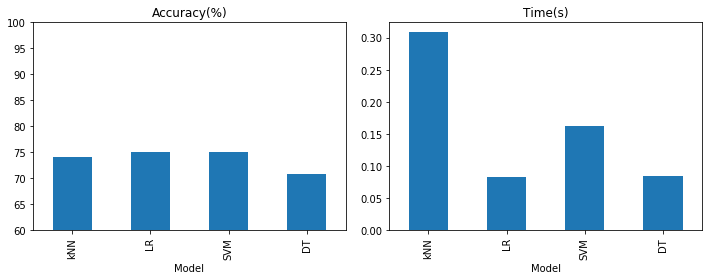

In [34]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
results_df.plot(y=['Accuracy (%)'], kind='bar', ylim=[60, 100], ax=ax1, title='Accuracy(%)', legend=False)

ax2 = plt.subplot(1, 2, 2)
results_df.plot(y=['Time (s)'], kind='bar', ax=ax2, title='Time(s)', legend=False)
plt.tight_layout()
plt.show()